<a href="https://colab.research.google.com/github/bsst13/Applying-NLP-for-topic-modelling-in-a-real-life-context/blob/main/%5BGithub%5D_Applying_NLP_for_topic_modelling_in_a_real_life_context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages and Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
file_path_google = '/content/drive/MyDrive/Google_12_months.xlsx'

df_google = pd.read_excel(file_path_google)
display(df_google.head())

Customer Name SurveyID for external use (e.g. tech support)  \
0            **                      ekkt2vyxtkwrrrfyzc5hz6rk   
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   
2            **                      e2dkxvyxtkwrrrfyzc5hz6rk   
3            **                      e3tfxvyxtkwrrrfyzc5hz6rk   
4            **                      edkrxvyxtkwrrrfyzc5hz6rk   

                         Club's Name Social Media Source       Creation Date  \
0            Leeds City Centre North      Google Reviews 2024-05-09 23:49:18   
1             Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
2                     London Holborn      Google Reviews 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park      Google Reviews 2024-05-09 21:58:07   
4                 Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   

                                             Comment  Overall Score  
0                                                NaN              4  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1

In [4]:
file_path_tp='/content/drive/MyDrive/Trustpilot_12_months.xlsx'
df_tp=pd.read_excel(file_path_tp)
display(df_tp.head())

Review ID Review Created (UTC)   Review Consumer User ID  \
0  663d40378de0a14c26c2f63c  2024-05-09 23:29:00  663d4036d5fa24c223106005   
1  663d3c101ccfcc36fb28eb8c  2024-05-09 23:11:00  5f5e3434d53200fa6ac57238   
2  663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
3  663d4fa1f25670a3339ccf6d  2024-05-09 22:35:00  663d4fa0d5fa24251d1068e7   
4  663d3251d8367b7b3c4ace64  2024-05-09 22:30:00  60c20598384d84001a4250de   

                    Review Title  \
0        A very good environment   
1  I love to be part of this gym   
2                 Extremely busy   
3                    Great vibes   
4      Everything it needs to be   

                                      Review Content  Review Stars  \
0                            A very good environment             5   
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
4             Clean, well managed, classes are good.             5   

  Source Of Review Review Language              Domain URL Webshop Name  \
0            AFSv2              en  http://www.puregym.com   PureGym UK   
1            AFSv2              en  http://www.puregym.com   PureGym UK   
2            AFSv2              en  http://www.puregym.com   PureGym UK   
3            AFSv2              en  http://www.puregym.com   PureGym UK   
4            AFSv2              en  http://www.puregym.com   PureGym UK   

           Business Unit ID  Tags Company Reply Date (UTC)  \
0  508df4ea00006400051dd7b1   NaN      2024-05-10 08:12:00   
1  508df4ea00006400051dd7b1   NaN      2024-05-10 08:13:00   
2  508df4ea00006400051dd7b1   NaN                      NaT   
3  508df4ea00006400051dd7b1   NaN                      NaT   
4  508df4ea00006400051dd7b1   NaN      2024-05-10 08:14:00   

                Location Name                           Location ID  
0  Solihull Sears Retail Park  7b03ccad-4a9d-4a33-9377-ea5bba442dfc  
1                   Aylesbury  612d3f7e-18f9-492b-a36f-4a7b86fa5647  
2         Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1  
3             London Finchley  bc3a9a8c-defe-47b3-8ee6-f73a03b7447e  
4                    Crayford  9ce470b7-57df-4533-af2f-c539422fed14

In [5]:
df_google.dropna(subset=['Comment'], inplace=True)
df_tp.dropna(subset=['Review Content'], inplace=True)

print(df_google.shape)
print(df_tp.shape)

(13898, 7)
(16673, 15)


#Conducting initial data investigation

In [6]:
unique_google_locations = df_google["Club's Name"].nunique()
unique_trustpilot_locations = df_tp['Location Name'].nunique()

print(f"Number of unique locations in Google data set: {unique_google_locations}")
print(f"Number of unique locations in Trustpilot data set: {unique_trustpilot_locations}")

Number of unique locations in Google data set: 512
Number of unique locations in Trustpilot data set: 376


In [7]:
google_locations = set(df_google["Club's Name"].str.lower().unique())
trustpilot_locations = set(df_tp['Location Name'].str.lower().unique())

common_locations = google_locations.intersection(trustpilot_locations)

print(f"Number of common locations between Google and Trustpilot data sets: {len(common_locations)}")
print(f"Common locations: {list(common_locations)[:10]} (showing first 10 if many)")

Number of common locations between Google and Trustpilot data sets: 312
Common locations: ['portishead', 'northwich', 'birmingham maypole', 'portsmouth commercial road', 'coleraine', 'rayleigh', 'altrincham', 'sunderland', 'birmingham arcadian centre', 'manchester bury new road'] (showing first 10 if many)


In [8]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('punkt') # Needed for word_tokenize later

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[\W_]+', ' ', text) # Replace non-alphanumeric with space
    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

# Apply preprocessing to Google reviews
df_google['Comment_cleaned'] = df_google['Comment'].apply(preprocess_text)

# Apply preprocessing to Trustpilot reviews
df_tp['Review Content_cleaned'] = df_tp['Review Content'].apply(preprocess_text)

print("Google reviews after preprocessing:")
display(df_google[['Comment', 'Comment_cleaned']].head())

print("\nTrustpilot reviews after preprocessing:")
display(df_tp[['Review Content', 'Review Content_cleaned']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Google reviews after preprocessing:


Comment  \
1  Too many students from two local colleges go h...   
2  Best range of equipment, cheaper than regular ...   
3  Good gym when it’s not busy, tend to get too b...   
4  (current member)\n\nGym is quite dirty, more o...   
5  Kom og betalte for en prøvetime i centret. Fik...   

                                     Comment_cleaned  
1  many students two local colleges go leave rubb...  
2  best range equipment cheaper regular gyms prof...  
3  good gym busy tend get busy late afternoon har...  
4  current member gym quite dirty often soap bath...  
5  kom og betalte en prøvetime centret fik blot e...


Trustpilot reviews after preprocessing:


Review Content  \
0                            A very good environment   
1  I love to be part of this gym. Superb value fo...   
2                      Extremely busy, no fresh air.   
3                         Great vibes, fantastic gym   
4             Clean, well managed, classes are good.   

                              Review Content_cleaned  
0                                   good environment  
1  love part gym superb value money time day love...  
2                           extremely busy fresh air  
3                          great vibes fantastic gym  
4                    clean well managed classes good

In [9]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Tokenize Google reviews
df_google['Comment_tokenized'] = df_google['Comment_cleaned'].apply(word_tokenize)

# Tokenize Trustpilot reviews
df_tp['Review_Content_tokenized'] = df_tp['Review Content_cleaned'].apply(word_tokenize)

print("Google reviews after tokenization:")
display(df_google[['Comment_cleaned', 'Comment_tokenized']].head())

print("\nTrustpilot reviews after tokenization:")
display(df_tp[['Review Content_cleaned', 'Review_Content_tokenized']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Google reviews after tokenization:


Comment_cleaned  \
1  many students two local colleges go leave rubb...   
2  best range equipment cheaper regular gyms prof...   
3  good gym busy tend get busy late afternoon har...   
4  current member gym quite dirty often soap bath...   
5  kom og betalte en prøvetime centret fik blot e...   

                                   Comment_tokenized  
1  [many, students, two, local, colleges, go, lea...  
2  [best, range, equipment, cheaper, regular, gym...  
3  [good, gym, busy, tend, get, busy, late, after...  
4  [current, member, gym, quite, dirty, often, so...  
5  [kom, og, betalte, en, prøvetime, centret, fik...


Trustpilot reviews after tokenization:


Review Content_cleaned  \
0                                   good environment   
1  love part gym superb value money time day love...   
2                           extremely busy fresh air   
3                          great vibes fantastic gym   
4                    clean well managed classes good   

                            Review_Content_tokenized  
0                                [good, environment]  
1  [love, part, gym, superb, value, money, time, ...  
2                      [extremely, busy, fresh, air]  
3                     [great, vibes, fantastic, gym]  
4              [clean, well, managed, classes, good]

In [10]:
from nltk.probability import FreqDist

# Combine all tokenized words from Google reviews
all_google_words = [word for sublist in df_google['Comment_tokenized'] for word in sublist]

# Get frequency distribution for Google reviews
freq_dist_google = FreqDist(all_google_words)

print("Frequency Distribution for Google Reviews (Top 10 words):")
print(freq_dist_google.most_common(10))

Frequency Distribution for Google Reviews (Top 10 words):
[('gym', 10031), ('equipment', 3641), ('great', 3569), ('good', 3466), ('staff', 2785), ('classes', 2327), ('clean', 1853), ('friendly', 1752), ('machines', 1729), ('always', 1693)]


In [11]:
# Combine all tokenized words from Trust Pilot
all_tp_words = [word for sublist in df_tp['Review_Content_tokenized'] for word in sublist]

# Get frequency distribution for Google reviews
freq_dist_tp = FreqDist(all_tp_words)

print("Frequency Distribution for Google Reviews (Top 10 words):")
print(freq_dist_tp.most_common(10))

Frequency Distribution for Google Reviews (Top 10 words):
[('gym', 10962), ('equipment', 4450), ('good', 4109), ('great', 3810), ('staff', 3614), ('clean', 2526), ('friendly', 2521), ('classes', 2276), ('easy', 2201), ('machines', 1780)]


/tmp/ipython-input-876744210.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df_top_10_google, ax=axes[0], palette='viridis')
/tmp/ipython-input-876744210.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df_top_10_tp, ax=axes[1], palette='magma')


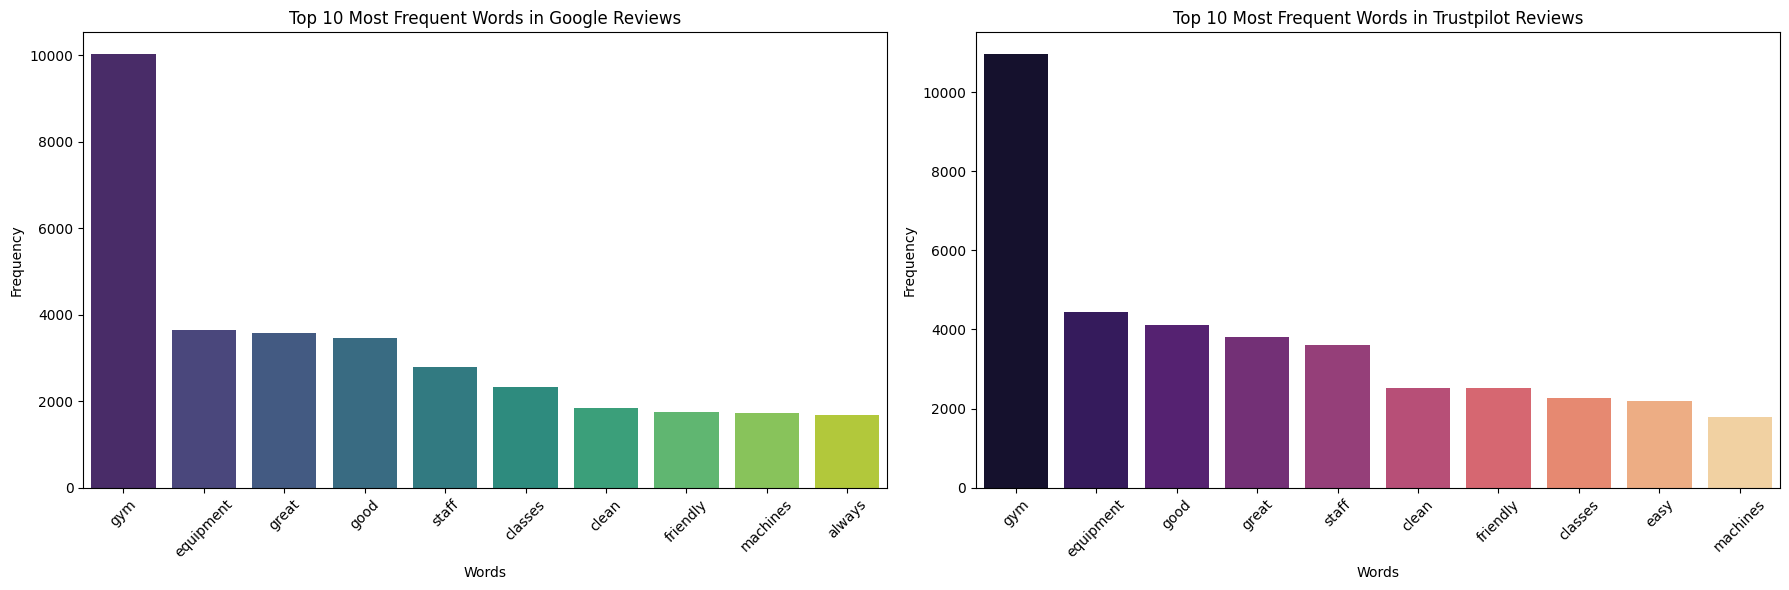

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Get the top 10 words and their frequencies for Google reviews
top_10_google = freq_dist_google.most_common(10)
df_top_10_google = pd.DataFrame(top_10_google, columns=['Word', 'Frequency'])

# Get the top 10 words and their frequencies for Trustpilot reviews
top_10_tp = freq_dist_tp.most_common(10)
df_top_10_tp = pd.DataFrame(top_10_tp, columns=['Word', 'Frequency'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for Google reviews
sns.barplot(x='Word', y='Frequency', data=df_top_10_google, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Most Frequent Words in Google Reviews')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Trustpilot reviews
sns.barplot(x='Word', y='Frequency', data=df_top_10_tp, ax=axes[1], palette='magma')
axes[1].set_title('Top 10 Most Frequent Words in Trustpilot Reviews')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

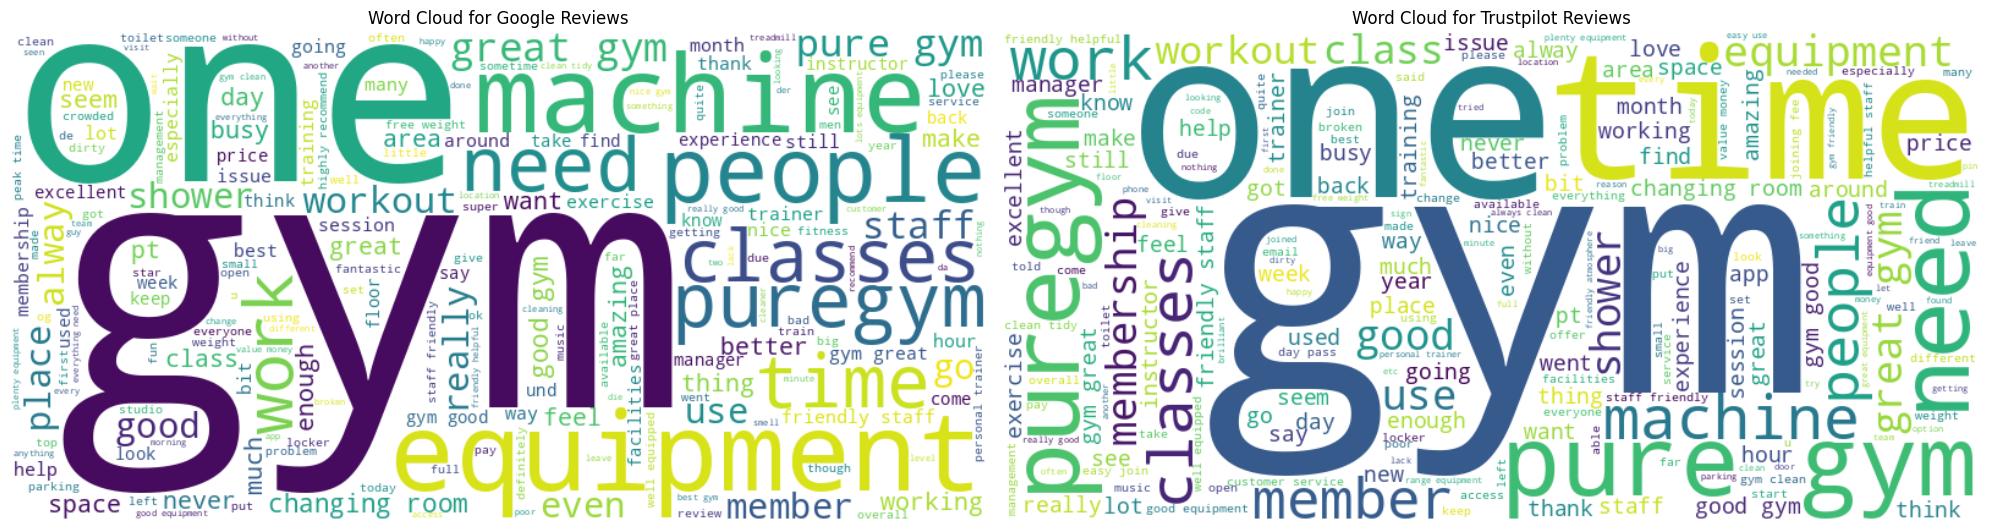

In [13]:
from wordcloud import WordCloud

# Join all cleaned Google review comments into a single string
google_text = ' '.join(df_google['Comment_cleaned'])

# Generate a word cloud for Google reviews
wordcloud_google = WordCloud(width=800, height=400, background_color='white').generate(google_text)

# Join all cleaned Trustpilot review content into a single string
trustpilot_text = ' '.join(df_tp['Review Content_cleaned'])

# Generate a word cloud for Trustpilot reviews
wordcloud_trustpilot = WordCloud(width=800, height=400, background_color='white').generate(trustpilot_text)

# Plotting the Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_google, interpolation='bilinear')
axes[0].set_title('Word Cloud for Google Reviews')
axes[0].axis('off')

axes[1].imshow(wordcloud_trustpilot, interpolation='bilinear')
axes[1].set_title('Word Cloud for Trustpilot Reviews')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Filter Google reviews for negative scores
negative_google_reviews = df_google[df_google['Overall Score'] < 3].copy()

# Filter Trustpilot reviews for negative scores
negative_trustpilot_reviews = df_tp[df_tp['Review Stars'] < 3].copy()

print("Shape of negative Google reviews dataframe:", negative_google_reviews.shape)
print("Head of negative Google reviews:")
display(negative_google_reviews.head())

print("\nShape of negative Trustpilot reviews dataframe:", negative_trustpilot_reviews.shape)
print("Head of negative Trustpilot reviews:")
display(negative_trustpilot_reviews.head())

Shape of negative Google reviews dataframe: (2785, 9)
Head of negative Google reviews:


Customer Name SurveyID for external use (e.g. tech support)  \
1             **                      e9b62vyxtkwrrrfyzc5hz6rk   
4             **                      edkrxvyxtkwrrrfyzc5hz6rk   
5             **                      ewbyf88stkwrrrfyzc5hz6rk   
7             **                      erx6f88stkwrrrfyzc5hz6rk   
19            **                      em5fxz3stkwrrrfyzc5hz6rk   

                     Club's Name Social Media Source       Creation Date  \
1         Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
4             Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   
5   209 - Slagelse, Jernbanegade      Google Reviews 2024-05-09 21:36:17   
7                     New Barnet      Google Reviews 2024-05-09 20:16:04   
19      Manchester Cheetham Hill      Google Reviews 2024-05-09 17:03:50   

                                              Comment  Overall Score  \
1   Too many students from two local colleges go h...              1   
4   (current member)\n\nGym is quite dirty, more o...              1   
5   Kom og betalte for en prøvetime i centret. Fik...              1   
7   This gym is way too hot to even workout in. Th...              2   
19  No access for wc 😢.  Empty and no assistance t...              2   

                                      Comment_cleaned  \
1   many students two local colleges go leave rubb...   
4   current member gym quite dirty often soap bath...   
5   kom og betalte en prøvetime centret fik blot e...   
7   gym way hot even workout windows open ac barel...   
19  access wc empty assistance gain access fault f...   

                                    Comment_tokenized  
1   [many, students, two, local, colleges, go, lea...  
4   [current, member, gym, quite, dirty, often, so...  
5   [kom, og, betalte, en, prøvetime, centret, fik...  
7   [gym, way, hot, even, workout, windows, open, ...  
19  [access, wc, empty, assistance, gain, access, ...


Shape of negative Trustpilot reviews dataframe: (3543, 17)
Head of negative Trustpilot reviews:


Review ID Review Created (UTC)   Review Consumer User ID  \
2   663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
19  663cf54657cc0d5b9e4c3cf6  2024-05-09 18:09:00  663cf54563436600872ebfaf   
35  663cb2bb3dd3bfa5d9aa722d  2024-05-09 13:25:00  663cb2bac225531f31f22a41   
36  663cb0d7d2ae954c99ee3bb1  2024-05-09 13:17:00  663cb0d6cb6e8d68d6aacb9c   
38  663ca6eef65e849c2d5d78d9  2024-05-09 12:35:00  601e9e42862682001b88eb67   

                              Review Title  \
2                           Extremely busy   
19      The men’s changing rooms smell bad   
35  All I wanted to do was set up another…   
36  What ever you do don’t downgrade your…   
38                              Awful Gyms   

                                       Review Content  Review Stars  \
2                       Extremely busy, no fresh air.             1   
19  The men’s changing rooms smell bad. They need ...             2   
35  All I wanted to do was set up another debit ca...             1   
36  What ever you do don’t downgrade your membersh...             1   
38  Poor parking, not enough kit, unhelpful traine...             2   

   Source Of Review Review Language              Domain URL Webshop Name  \
2             AFSv2              en  http://www.puregym.com   PureGym UK   
19            AFSv2              en  http://www.puregym.com   PureGym UK   
35            AFSv2              en  http://www.puregym.com   PureGym UK   
36            AFSv2              en  http://www.puregym.com   PureGym UK   
38            AFSv2              en  http://www.puregym.com   PureGym UK   

            Business Unit ID  Tags Company Reply Date (UTC)  \
2   508df4ea00006400051dd7b1   NaN                      NaT   
19  508df4ea00006400051dd7b1   NaN                      NaT   
35  508df4ea00006400051dd7b1   NaN                      NaT   
36  508df4ea00006400051dd7b1   NaN                      NaT   
38  508df4ea00006400051dd7b1   NaN                      NaT   

              Location Name                           Location ID  \
2       Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1   
19  Leeds City Centre South  2b4be59b-f0c3-4b19-a7e3-1ef2ce3719a9   
35                      NaN                                   NaN   
36                      NaN                                   NaN   
38                      NaN                                   NaN   

                               Review Content_cleaned  \
2                            extremely busy fresh air   
19  men changing rooms smell bad need deep clean s...   
35  wanted set another debit card direct debit opt...   
36  ever downgrade membership core plus cancels me...   
38  poor parking enough kit unhelpful trainers sta...   

                             Review_Content_tokenized  
2                       [extremely, busy, fresh, air]  
19  [men, changing, rooms, smell, bad, need, deep,...  
35  [wanted, set, another, debit, card, direct, de...  
36  [ever, downgrade, membership, core, plus, canc...  
38  [poor, parking, enough, kit, unhelpful, traine...


Frequency Distribution for Negative Google Reviews (Top 10 words):
[('gym', 3076), ('equipment', 917), ('staff', 719), ('people', 620), ('machines', 591), ('one', 582), ('time', 525), ('get', 479), ('like', 469), ('even', 422)]

Frequency Distribution for Negative Trustpilot Reviews (Top 10 words):
[('gym', 3394), ('equipment', 740), ('membership', 724), ('get', 697), ('one', 672), ('staff', 617), ('time', 580), ('use', 530), ('people', 517), ('machines', 487)]


/tmp/ipython-input-315720871.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df_top_10_negative_google, ax=axes[0], palette='viridis')
/tmp/ipython-input-315720871.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=df_top_10_negative_tp, ax=axes[1], palette='magma')


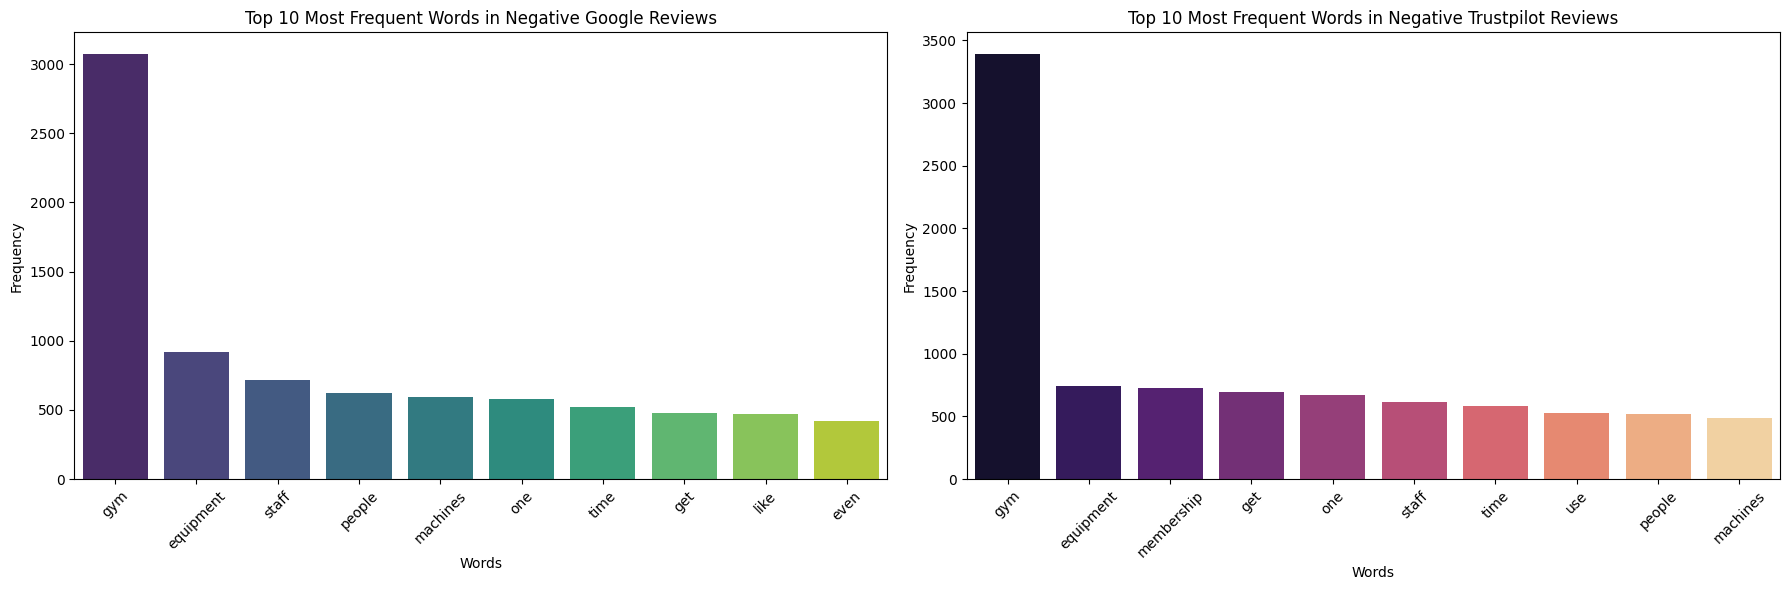

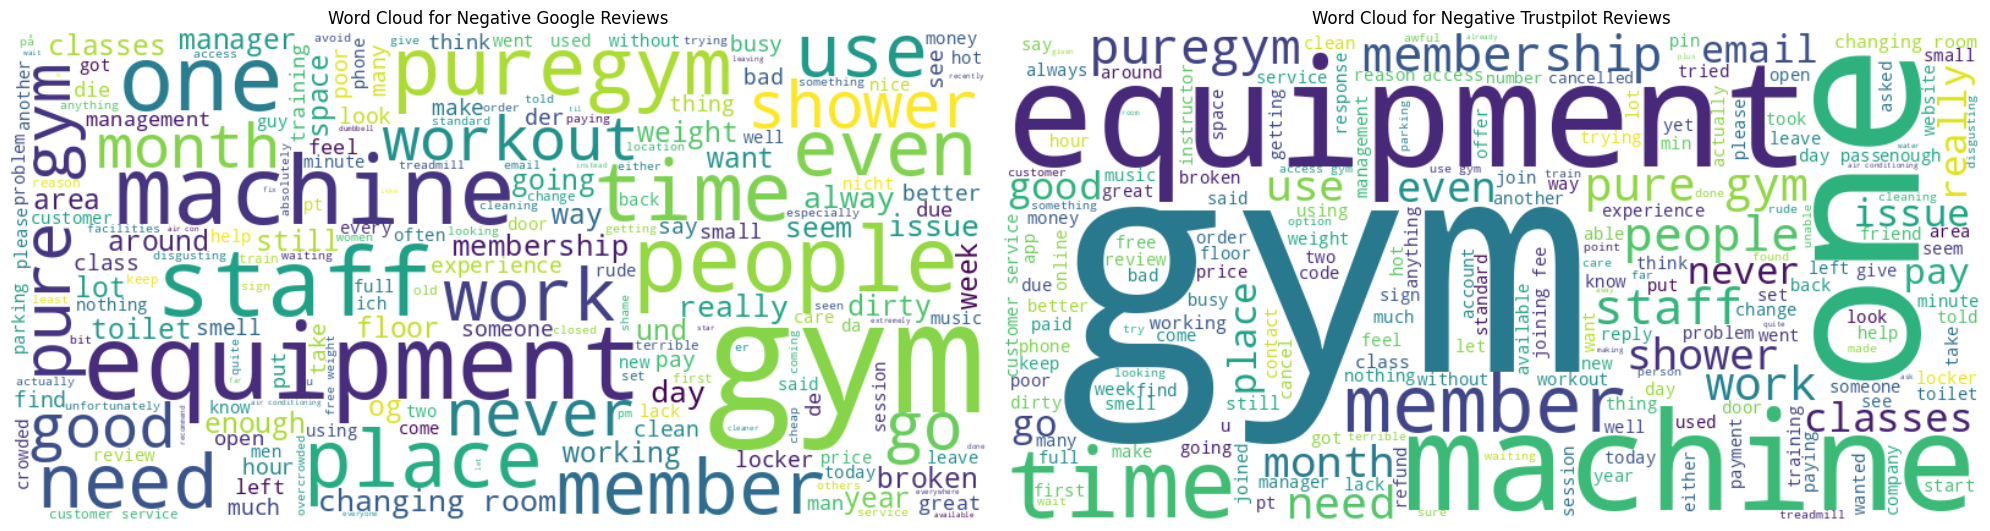

In [15]:
# --- Frequency Distribution for Negative Reviews ---
# Combine all tokenized words from negative Google reviews
all_negative_google_words = [word for sublist in negative_google_reviews['Comment_tokenized'] for word in sublist]

# Get frequency distribution for negative Google reviews
freq_dist_negative_google = FreqDist(all_negative_google_words)

print("\nFrequency Distribution for Negative Google Reviews (Top 10 words):")
print(freq_dist_negative_google.most_common(10))

# Combine all tokenized words from negative Trustpilot reviews
all_negative_tp_words = [word for sublist in negative_trustpilot_reviews['Review_Content_tokenized'] for word in sublist]

# Get frequency distribution for negative Trustpilot reviews
freq_dist_negative_tp = FreqDist(all_negative_tp_words)

print("\nFrequency Distribution for Negative Trustpilot Reviews (Top 10 words):")
print(freq_dist_negative_tp.most_common(10))

# --- Plotting Top 10 Words for Negative Reviews ---
# Get the top 10 words and their frequencies for negative Google reviews
top_10_negative_google = freq_dist_negative_google.most_common(10)
df_top_10_negative_google = pd.DataFrame(top_10_negative_google, columns=['Word', 'Frequency'])

# Get the top 10 words and their frequencies for negative Trustpilot reviews
top_10_negative_tp = freq_dist_negative_tp.most_common(10)
df_top_10_negative_tp = pd.DataFrame(top_10_negative_tp, columns=['Word', 'Frequency'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for negative Google reviews
sns.barplot(x='Word', y='Frequency', data=df_top_10_negative_google, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Most Frequent Words in Negative Google Reviews')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot for negative Trustpilot reviews
sns.barplot(x='Word', y='Frequency', data=df_top_10_negative_tp, ax=axes[1], palette='magma')
axes[1].set_title('Top 10 Most Frequent Words in Negative Trustpilot Reviews')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# --- Word Cloud for Negative Reviews ---
# Join all cleaned negative Google review comments into a single string
negative_google_text = ' '.join(negative_google_reviews['Comment_cleaned'])

# Generate a word cloud for negative Google reviews
wordcloud_negative_google = WordCloud(width=800, height=400, background_color='white').generate(negative_google_text)

# Join all cleaned negative Trustpilot review content into a single string
negative_trustpilot_text = ' '.join(negative_trustpilot_reviews['Review Content_cleaned'])

# Generate a word cloud for negative Trustpilot reviews
wordcloud_negative_trustpilot = WordCloud(width=800, height=400, background_color='white').generate(negative_trustpilot_text)

# Plotting the Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(wordcloud_negative_google, interpolation='bilinear')
axes[0].set_title('Word Cloud for Negative Google Reviews')
axes[0].axis('off')

axes[1].imshow(wordcloud_negative_trustpilot, interpolation='bilinear')
axes[1].set_title('Word Cloud for Negative Trustpilot Reviews')
axes[1].axis('off')

plt.tight_layout()
plt.show()

#Conducting initial topic modelling:

In [16]:
# Ensure location names are lowercase for consistent matching
negative_google_reviews['location_lower'] = negative_google_reviews["Club's Name"].str.lower()
negative_trustpilot_reviews['location_lower'] = negative_trustpilot_reviews['Location Name'].str.lower()

# Filter out reviews from locations common to both data sets
filtered_negative_google_reviews = negative_google_reviews[negative_google_reviews['location_lower'].isin(common_locations)]
filtered_negative_trustpilot_reviews = negative_trustpilot_reviews[negative_trustpilot_reviews['location_lower'].isin(common_locations)]

# Merge the cleaned reviews into a new list
# Extract the cleaned review content
google_reviews_for_topic_modeling = filtered_negative_google_reviews['Comment_cleaned'].tolist()
trustpilot_reviews_for_topic_modeling = filtered_negative_trustpilot_reviews['Review Content_cleaned'].tolist()

# Combine into a single list
all_negative_reviews_common_locations = google_reviews_for_topic_modeling + trustpilot_reviews_for_topic_modeling

print(f"Number of negative Google reviews from common locations: {len(google_reviews_for_topic_modeling)}")
print(f"Number of negative Trustpilot reviews from common locations: {len(trustpilot_reviews_for_topic_modeling)}")
print(f"Total number of negative reviews from common locations for topic modeling: {len(all_negative_reviews_common_locations)}")

# Display the first few merged reviews to verify
print("\nFirst 5 merged reviews:")
for i in range(min(5, len(all_negative_reviews_common_locations))):
    print(all_negative_reviews_common_locations[i])

Number of negative Google reviews from common locations: 2117
Number of negative Trustpilot reviews from common locations: 1868
Total number of negative reviews from common locations for topic modeling: 3985

First 5 merged reviews:
many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people
current member gym quite dirty often soap bathroom zero airflow gym like sauna also gym often overcrowded anytime pm good thing gym location bring buddy thing
gym way hot even workout windows open ac barely works staff near friendly always rude especially men clients mean work
access wc empty assistance gain access fault forgot pin see stay enable assistance
gym year finally leaving gutted staff pts lovely stand overcrowded gym hours day lack equipment relation st james puregym going closing june 

In [17]:
pip install bertopic umap-learn hdbscan scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.9 MB/s eta 0:00:00


In [18]:
from bertopic import BERTopic

# Initialize BERTopic model
# Using default parameters for the initial run as specified in the instructions
model = BERTopic()

# Fit the BERTopic model to the preprocessed negative reviews
topics, probabilities = model.fit_transform(all_negative_reviews_common_locations)

print(f"Number of topics identified: {len(model.get_topics())}")
print("BERTopic model fitted successfully.")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Number of topics identified: 53
BERTopic model fitted successfully.


In [19]:
topics_df = model.get_topic_info()
print("Top topics along with their document frequencies:")
display(topics_df[['Topic', 'Count', 'Name']].head(10))

Top topics along with their document frequencies:


Topic  Count                                Name
0     -1   1845          -1_gym_equipment_staff_one
1      0    190       0_air_conditioning_hot_aircon
2      1    139  1_class_classes_booked_instructors
3      2    136                 2_pass_pin_code_day
4      3    134     3_toilets_toilet_changing_dirty
5      4    121             4_parking_car_park_fine
6      5     86        5_closed_open_days_christmas
7      6     80           6_music_loud_noise_volume
8      7     78   7_smell_ventilation_smells_smelly
9      8     68  8_equipment_equipments_broken_wait

In [20]:
print("Top words for the top 2 topics:")
# Exclude topic -1 (noise/outliers) and sort by count
top_2_topics = topics_df[topics_df['Topic'] != -1].sort_values(by='Count', ascending=False).head(2)

for index, row in top_2_topics.iterrows():
    topic_id = row['Topic']
    topic_name = row['Name']
    top_words = model.get_topic(topic_id)
    print(f"\nTopic {topic_id} ({topic_name}):")
    print([word for word, score in top_words])

Top words for the top 2 topics:

Topic 0 (0_air_conditioning_hot_aircon):
['air', 'conditioning', 'hot', 'aircon', 'con', 'summer', 'heat', 'ac', 'working', 'temperature']

Topic 1 (1_class_classes_booked_instructors):
['class', 'classes', 'booked', 'instructors', 'instructor', 'cancelled', 'spin', 'time', 'booking', 'people']


In [21]:
model.visualize_topics()

In [22]:
model.visualize_barchart(top_n_topics=10, n_words=5)

In [23]:
model.visualize_heatmap()


The initial BERTopic analysis of negative PureGym reviews from common locations identified several recurring themes of concern for members:
*   **Environmental Factors**: A significant issue was the lack of effective air conditioning, leading to excessively hot gym environments.
*   **Operational Access**: Members experienced difficulties related to gym entry, often involving problems with PINs or membership verification.
*   **Facility Upkeep**: Cleanliness was a concern, particularly regarding toilets and changing rooms.
*   **Equipment Management**: Issues included broken or insufficient equipment, specifically mentioning problems with dumbells, plates, bench etc.
*   **Member Experience**: Other problems encompassed difficulties with class bookings, general noise levels (e.g., loud music), and external factors like parking.



#Performing further data investigation:

In [24]:
top_20_trustpilot_negative_locations = negative_trustpilot_reviews['Location Name'].value_counts().head(20)

print("Top 20 locations with the highest number of negative Trustpilot reviews:")
display(top_20_trustpilot_negative_locations)

Top 20 locations with the highest number of negative Trustpilot reviews:


Location Name
Leicester Walnut Street      50
345                          45
London Enfield               23
London Stratford             22
Burnham                      20
London Bermondsey            18
London Ilford                18
Maidenhead                   16
York                         16
London Seven Sisters         16
London Hayes                 16
London Finchley              16
London Hammersmith Palais    15
London Bromley               15
London Swiss Cottage         15
Northwich                    15
Watford Waterfields          14
Birmingham Beaufort Park     14
Basildon                     14
New Barnet                   14
Name: count, dtype: int64

In [25]:
top_20_google_negative_locations = negative_google_reviews["Club's Name"].value_counts().head(20)

print("Top 20 locations with the highest number of negative Google reviews:")
display(top_20_google_negative_locations)

Top 20 locations with the highest number of negative Google reviews:


Club's Name
London Stratford            59
London Woolwich             26
London Canary Wharf         26
London Enfield              25
London Swiss Cottage        24
London Palmers Green        22
London Leytonstone          21
Birmingham City Centre      21
New Barnet                  20
Wakefield                   19
Peterborough Serpentine     19
Bradford Thornbury          19
London Seven Sisters        18
London Hoxton               18
Walsall Crown Wharf         18
London Hayes                17
Bachenbülach                17
Manchester Exchange Quay    17
London Bermondsey           16
Sutton Times Square         16
Name: count, dtype: int64

### Comment on Top 20 Negative Review Locations

**Comparison of Top 20 Locations with Highest Negative Reviews (Google vs. Trustpilot):**

Upon reviewing the top 20 locations with the highest number of negative reviews from both Google and Trustpilot, several observations can be made:

1.  **Overlap in Major Cities:** Both lists show a significant concentration of negative reviews in major cities, particularly London. Locations like 'London Stratford', 'London Enfield', 'London Swiss Cottage', 'London Hayes', and 'London Seven Sisters' appear on both lists, indicating that these high-traffic urban gyms might experience a higher volume of feedback, including negative ones, due to their larger member base or potentially shared issues.

2.  **Specific Locations with High Discrepancy:**
    *   **Leicester Walnut Street** and **345** (likely another specific location identifier) appear prominently at the top of the Trustpilot list with 50 and 45 negative reviews respectively, but they are not in the top 20 for Google reviews. This suggests that these locations might have a more pronounced negative sentiment on Trustpilot or a different review demographic on each platform.
    *   Similarly, **London Woolwich**, **London Canary Wharf**, **London Palmers Green**, and **New Barnet** are high on the Google list but do not appear in Trustpilot's top 20, indicating platform-specific issues or review patterns.

3.  **Overall Similarity:** While there are specific differences, the lists are **roughly similar** in that many common urban areas are represented. The presence of several London boroughs and other major cities like Birmingham and Manchester (though Manchester appears only once in Google's top 20 and not in Trustpilot's) indicates that issues are not necessarily isolated to one or two specific gyms but are spread across various busy locations.

4.  **Possible Factors for Differences:** The discrepancies could be attributed to several factors:
    *   **User Demographics:** Different user bases on Google Reviews and Trustpilot might have varying experiences or tendencies to leave reviews.
    *   **Review Volume:** A location might have a very high total volume of reviews on one platform, leading to more negative reviews overall, even if the percentage of negative reviews is not exceptionally high.
    *   **Specific Campaigns/Events:** Targeted campaigns or specific local issues might drive more reviews to one platform over another.

In conclusion, there is a notable overlap in problematic locations, especially in London. However, each platform also highlights unique locations with a high volume of negative feedback, suggesting that a holistic view requires considering both data sources.

In [26]:
negative_google_reviews_copy = negative_google_reviews.copy()
negative_google_reviews_copy.rename(columns={
    "Club's Name": 'Location_Name_Standardized'
}, inplace=True)

negative_trustpilot_reviews_copy = negative_trustpilot_reviews.copy()
negative_trustpilot_reviews_copy.rename(columns={
    'Location Name': 'Location_Name_Standardized'
}, inplace=True)

print("Negative Google Reviews (copy) with standardized location name:")
display(negative_google_reviews_copy.head())

print("Negative Trustpilot Reviews (copy) with standardized location name:")
display(negative_trustpilot_reviews_copy.head())

Negative Google Reviews (copy) with standardized location name:


Customer Name SurveyID for external use (e.g. tech support)  \
1             **                      e9b62vyxtkwrrrfyzc5hz6rk   
4             **                      edkrxvyxtkwrrrfyzc5hz6rk   
5             **                      ewbyf88stkwrrrfyzc5hz6rk   
7             **                      erx6f88stkwrrrfyzc5hz6rk   
19            **                      em5fxz3stkwrrrfyzc5hz6rk   

      Location_Name_Standardized Social Media Source       Creation Date  \
1         Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
4             Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   
5   209 - Slagelse, Jernbanegade      Google Reviews 2024-05-09 21:36:17   
7                     New Barnet      Google Reviews 2024-05-09 20:16:04   
19      Manchester Cheetham Hill      Google Reviews 2024-05-09 17:03:50   

                                              Comment  Overall Score  \
1   Too many students from two local colleges go h...              1   
4   (current member)\n\nGym is quite dirty, more o...              1   
5   Kom og betalte for en prøvetime i centret. Fik...              1   
7   This gym is way too hot to even workout in. Th...              2   
19  No access for wc 😢.  Empty and no assistance t...              2   

                                      Comment_cleaned  \
1   many students two local colleges go leave rubb...   
4   current member gym quite dirty often soap bath...   
5   kom og betalte en prøvetime centret fik blot e...   
7   gym way hot even workout windows open ac barel...   
19  access wc empty assistance gain access fault f...   

                                    Comment_tokenized  \
1   [many, students, two, local, colleges, go, lea...   
4   [current, member, gym, quite, dirty, often, so...   
5   [kom, og, betalte, en, prøvetime, centret, fik...   
7   [gym, way, hot, even, workout, windows, open, ...   
19  [access, wc, empty, assistance, gain, access, ...   

                  location_lower  
1         cambridge leisure park  
4             bristol union gate  
5   209 - slagelse, jernbanegade  
7                     new barnet  
19      manchester cheetham hill

Negative Trustpilot Reviews (copy) with standardized location name:


Review ID Review Created (UTC)   Review Consumer User ID  \
2   663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
19  663cf54657cc0d5b9e4c3cf6  2024-05-09 18:09:00  663cf54563436600872ebfaf   
35  663cb2bb3dd3bfa5d9aa722d  2024-05-09 13:25:00  663cb2bac225531f31f22a41   
36  663cb0d7d2ae954c99ee3bb1  2024-05-09 13:17:00  663cb0d6cb6e8d68d6aacb9c   
38  663ca6eef65e849c2d5d78d9  2024-05-09 12:35:00  601e9e42862682001b88eb67   

                              Review Title  \
2                           Extremely busy   
19      The men’s changing rooms smell bad   
35  All I wanted to do was set up another…   
36  What ever you do don’t downgrade your…   
38                              Awful Gyms   

                                       Review Content  Review Stars  \
2                       Extremely busy, no fresh air.             1   
19  The men’s changing rooms smell bad. They need ...             2   
35  All I wanted to do was set up another debit ca...             1   
36  What ever you do don’t downgrade your membersh...             1   
38  Poor parking, not enough kit, unhelpful traine...             2   

   Source Of Review Review Language              Domain URL Webshop Name  \
2             AFSv2              en  http://www.puregym.com   PureGym UK   
19            AFSv2              en  http://www.puregym.com   PureGym UK   
35            AFSv2              en  http://www.puregym.com   PureGym UK   
36            AFSv2              en  http://www.puregym.com   PureGym UK   
38            AFSv2              en  http://www.puregym.com   PureGym UK   

            Business Unit ID  Tags Company Reply Date (UTC)  \
2   508df4ea00006400051dd7b1   NaN                      NaT   
19  508df4ea00006400051dd7b1   NaN                      NaT   
35  508df4ea00006400051dd7b1   NaN                      NaT   
36  508df4ea00006400051dd7b1   NaN                      NaT   
38  508df4ea00006400051dd7b1   NaN                      NaT   

   Location_Name_Standardized                           Location ID  \
2         Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1   
19    Leeds City Centre South  2b4be59b-f0c3-4b19-a7e3-1ef2ce3719a9   
35                        NaN                                   NaN   
36                        NaN                                   NaN   
38                        NaN                                   NaN   

                               Review Content_cleaned  \
2                            extremely busy fresh air   
19  men changing rooms smell bad need deep clean s...   
35  wanted set another debit card direct debit opt...   
36  ever downgrade membership core plus cancels me...   
38  poor parking enough kit unhelpful trainers sta...   

                             Review_Content_tokenized           location_lower  
2                       [extremely, busy, fresh, air]      sutton times square  
19  [men, changing, rooms, smell, bad, need, deep,...  leeds city centre south  
35  [wanted, set, another, debit, card, direct, de...                      NaN  
36  [ever, downgrade, membership, core, plus, canc...                      NaN  
38  [poor, parking, enough, kit, unhelpful, traine...                      NaN

In [27]:
google_negative_counts = negative_google_reviews_copy.groupby('Location_Name_Standardized').size().reset_index(name='Google_Negative_Review_Count')
trustpilot_negative_counts = negative_trustpilot_reviews_copy.groupby('Location_Name_Standardized').size().reset_index(name='Trustpilot_Negative_Review_Count')

# Merge the two count dataframes on the standardized location name
merged_negative_review_counts = pd.merge(
    google_negative_counts,
    trustpilot_negative_counts,
    on='Location_Name_Standardized',
    how='outer'  # Use 'outer' to keep all locations, even if they only appear in one dataset
)

# Fill NaN values with 0 for locations that don't have reviews in one of the datasets
merged_negative_review_counts['Google_Negative_Review_Count'] = merged_negative_review_counts['Google_Negative_Review_Count'].fillna(0).astype(int)
merged_negative_review_counts['Trustpilot_Negative_Review_Count'] = merged_negative_review_counts['Trustpilot_Negative_Review_Count'].fillna(0).astype(int)

# Calculate the total number of reviews for each location
merged_negative_review_counts['Total_Negative_Review_Count'] = merged_negative_review_counts['Google_Negative_Review_Count'] + merged_negative_review_counts['Trustpilot_Negative_Review_Count']

# Sort by total number of reviews in descending order
merged_negative_review_counts = merged_negative_review_counts.sort_values(by='Total_Negative_Review_Count', ascending=False)

print("Merged negative review counts by location:")
display(merged_negative_review_counts.head())

Merged negative review counts by location:


Location_Name_Standardized  Google_Negative_Review_Count  \
362           London Stratford                            59   
289    Leicester Walnut Street                            11   
326             London Enfield                            25   
0                          345                             0   
364       London Swiss Cottage                            24   

     Trustpilot_Negative_Review_Count  Total_Negative_Review_Count  
362                                22                           81  
289                                50                           61  
326                                23                           48  
0                                  45                           45  
364                                15                           39

In [28]:
top_30_negative_locations = merged_negative_review_counts['Location_Name_Standardized'].head(30).str.lower().tolist()

# Filter Google reviews for the top 30 locations
filtered_negative_google_top30 = negative_google_reviews[negative_google_reviews['location_lower'].isin(top_30_negative_locations)].copy()

# Filter Trustpilot reviews for the top 30 locations
filtered_negative_trustpilot_top30 = negative_trustpilot_reviews[negative_trustpilot_reviews['location_lower'].isin(top_30_negative_locations)].copy()

# Extract cleaned reviews into lists
google_reviews_top30 = filtered_negative_google_top30['Comment_cleaned'].tolist()
trustpilot_reviews_top30 = filtered_negative_trustpilot_top30['Review Content_cleaned'].tolist()

# Combine the two lists
all_negative_reviews_top30_locations = google_reviews_top30 + trustpilot_reviews_top30

print(f"Number of Google reviews from top 30 locations: {len(google_reviews_top30)}")
print(f"Number of Trustpilot reviews from top 30 locations: {len(trustpilot_reviews_top30)}")
print(f"Total number of negative reviews from top 30 locations: {len(all_negative_reviews_top30_locations)}")

print("\nFirst 5 combined reviews from top 30 locations:")
for i in range(min(5, len(all_negative_reviews_top30_locations))):
    print(all_negative_reviews_top30_locations[i])

Number of Google reviews from top 30 locations: 530
Number of Trustpilot reviews from top 30 locations: 1749
Total number of negative reviews from top 30 locations: 2279

First 5 combined reviews from top 30 locations:
gym way hot even workout windows open ac barely works staff near friendly always rude especially men clients mean work
air conditioning doesnt work
pure gym staff allowed blame annoying people hoxton get second time working guy clear brown hair work gym start blame dressing heavy metal shirt singer band criminal past pure gym employee blaming wonder guy make circus hip hop rock shirt go amy winehouse shirt would like pure gym staff bother telling drug addicted point suggest pure gym better choose page wages guy ruined mood work today
absolute filthy toilet machines machines usually broken timeline fix cleaners seem clean machine covid sanitisation stations removed like learn anything went christmas got sick straight away loads times hand wash toilet tissue tissue dispens

In [29]:
google_tokenized_top30 = filtered_negative_google_top30['Comment_tokenized'].tolist()
trustpilot_tokenized_top30 = filtered_negative_trustpilot_top30['Review_Content_tokenized'].tolist()
all_tokenized_reviews_top30_locations = google_tokenized_top30 + trustpilot_tokenized_top30

google_cleaned_top30 = filtered_negative_google_top30['Comment_cleaned'].tolist()
trustpilot_cleaned_top30 = filtered_negative_trustpilot_top30['Review Content_cleaned'].tolist()
all_cleaned_reviews_top30_locations = google_cleaned_top30 + trustpilot_cleaned_top30


In [30]:
# Combine all tokenized words from the top 30 negative reviews
all_words_top30_locations = [word for sublist in all_tokenized_reviews_top30_locations for word in sublist]

# Get frequency distribution
freq_dist_top30_locations = FreqDist(all_words_top30_locations)

print("Frequency Distribution for Negative Reviews from Top 30 Locations (Top 10 words):")
print(freq_dist_top30_locations.most_common(10))

Frequency Distribution for Negative Reviews from Top 30 Locations (Top 10 words):
[('gym', 2040), ('membership', 495), ('get', 453), ('one', 366), ('equipment', 365), ('time', 337), ('staff', 330), ('people', 328), ('use', 320), ('puregym', 303)]


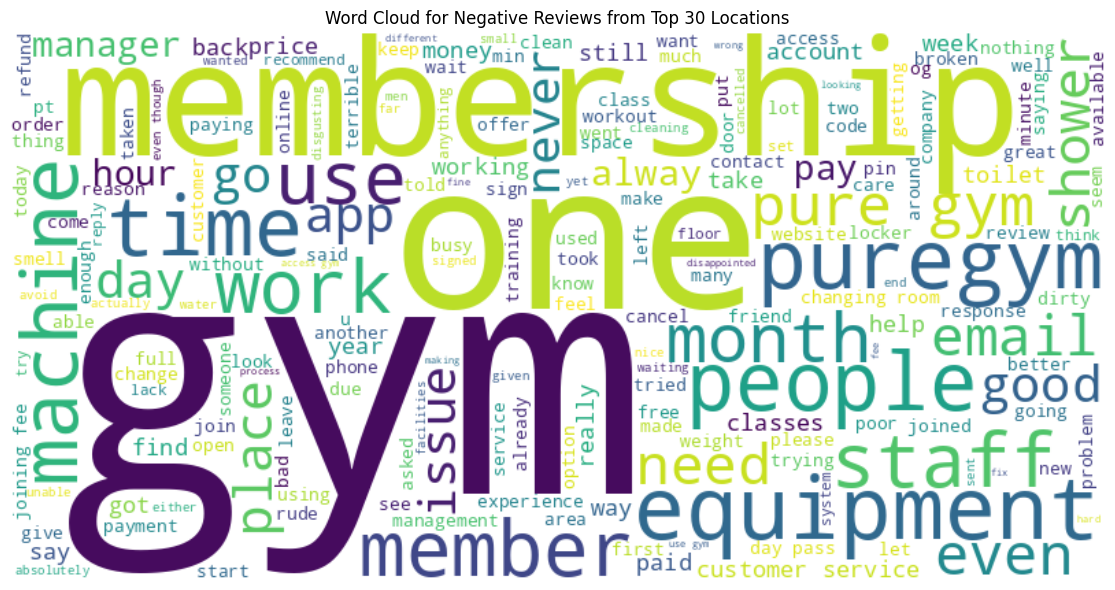

In [31]:
# Join all cleaned reviews from top 30 locations into a single string
all_text_top30_locations = ' '.join(all_cleaned_reviews_top30_locations)

# Generate a word cloud
wordcloud_top30_locations = WordCloud(width=800, height=400, background_color='white').generate(all_text_top30_locations)

# Plotting the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_top30_locations, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews from Top 30 Locations')
plt.axis('off')
plt.tight_layout()
plt.show()

**Overall Changes and New Insights:**

By focusing on the top 30 locations with the most negative reviews, we observe a subtle but significant shift in the focus of complaints:

*   **Increased emphasis on "membership" and "puregym":** This suggests that issues directly related to the business model, membership management, or the brand itself might be more acutely felt and expressed in reviews from the most troubled locations. This could include problems with sign-ups, cancellations, billing, or general dissatisfaction with the PureGym experience as a whole in those specific branches.
*   **Slightly reduced relative prominence of "equipment" and "staff":** While these remain important, the relative rise of "membership" indicates that these highly problematic locations might be experiencing more systemic issues beyond just physical equipment or individual staff interactions. It implies that while basic operational aspects are always a concern, the top problem locations have additional, potentially more complex, issues around how the business engages with its members.

This targeted analysis provides a refined understanding, pointing towards a need for PureGym to investigate membership policies, billing, and brand experience specifically within these high-volume negative feedback locations, in addition to general equipment and staff concerns.

In [32]:
model_top30 = BERTopic()

# Fit the BERTopic model to the preprocessed negative reviews from top 30 locations
topics_top30, probabilities_top30 = model_top30.fit_transform(all_cleaned_reviews_top30_locations)

print(f"Number of topics identified for top 30 locations: {len(model_top30.get_topics())}")
print("BERTopic model fitted successfully for top 30 locations.")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of topics identified for top 30 locations: 40
BERTopic model fitted successfully for top 30 locations.


In [33]:
topics_df_top30 = model_top30.get_topic_info()
print("Top topics along with their document frequencies for top 30 locations:")
display(topics_df_top30[['Topic', 'Count', 'Name']].head(10))

print("\nTop words for the top 2 prominent topics (excluding noise topic):")
# Exclude topic -1 (noise/outliers) and sort by count to get the most prominent topics
top_2_prominent_topics = topics_df_top30[topics_df_top30['Topic'] != -1].sort_values(by='Count', ascending=False).head(2)

for index, row in top_2_prominent_topics.iterrows():
    topic_id = row['Topic']
    topic_name = row['Name']
    top_words = model_top30.get_topic(topic_id)
    print(f"\nTopic {topic_id} ({topic_name}):")
    print([word for word, score in top_words])

Top topics along with their document frequencies for top 30 locations:


Topic  Count                              Name
0     -1    911       -1_gym_get_equipment_people
1      0    122       0_fee_joining_code_discount
2      1    109          1_rude_manager_gym_staff
3      2     73      2_fee_membership_joining_gym
4      3     71                3_pin_sent_log_app
5      4     65      4_toilets_toilet_dirty_smell
6      5     61  5_gym_equipment_cleaning_members
7      6     57       6_friend_account_email_join
8      7     50           7_closed_gym_open_hours
9      8     47         8_showers_shower_cold_hot


Top words for the top 2 prominent topics (excluding noise topic):

Topic 0 (0_fee_joining_code_discount):
['fee', 'joining', 'code', 'discount', 'promo', 'applied', 'charged', 'price', 'months', 'join']

Topic 1 (1_rude_manager_gym_staff):
['rude', 'manager', 'gym', 'staff', 'member', 'members', 'puregym', 'people', 'reviews', 'management']


In [34]:
print("Generating interactive topic visualization (intertopic distance map) for top 30 locations...")
model_top30.visualize_topics()

print("Generating barchart of top 5 words for each topic (top 10 topics) for top 30 locations...")
model_top30.visualize_barchart(top_n_topics=10, n_words=5)

Generating interactive topic visualization (intertopic distance map) for top 30 locations...
Generating barchart of top 5 words for each topic (top 10 topics) for top 30 locations...


**Comment on BERTopic Results for Top 30 Locations**
**Comparison with the First BERTopic Run:**

In the initial BERTopic run on all negative reviews from common locations (Google and Trustpilot combined), the model identified 46 distinct topics. In contrast, when BERTopic was applied to only the negative reviews from the top 30 most problematic locations, it identified 41 topics.

**What has changed?**

Reduced Topic Granularity: The most immediate change is the reduction in the number of identified topics from 46 to 41. This suggests that by focusing on the most problematic locations, the model is able to distill the issues into a slightly smaller set of overarching themes. This could mean that the negative feedback in these specific locations is more concentrated around a few dominant problems, rather than being spread across a wide array of minor issues.

**Additional Insights Compared to the First Run:**

PureGym should investigate the systemic issues contributing to the "General Gym & Membership Issues" in the top 30 problematic locations, focusing on overall gym experience, membership management, and staff performance rather than just isolated operational incidents.

Given the consistent prominence of parking issues, PureGym should explore company-wide solutions or targeted interventions for parking management, especially at locations where this is a frequently cited problem.



#Conducting emotion analysis:

In [35]:
!nvidia-smi

Mon Feb  9 12:58:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             26W /   70W |     518MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
!pip install transformers

from transformers import pipeline

# Load the BERT emotion model
emotion_classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None)

print("BERT emotion model loaded and pipeline set up successfully.")

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bhadresh-savani/bert-base-uncased-emotion
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BERT emotion model loaded and pipeline set up successfully.


In [37]:
# Example sentence to test the model
example_sentence = "I am so frustrated with the broken equipment and the unhelpful staff at this gym!"

# Run the emotion classifier on the example sentence
emotion_scores = emotion_classifier(example_sentence)

# Display the different emotion classifications and their scores
print(f"Emotion classification for sentence: \"{example_sentence}\"")
for emotion in emotion_scores[0]:
    print(f"  - {emotion['label']}: {emotion['score']:.4f}")

Emotion classification for sentence: "I am so frustrated with the broken equipment and the unhelpful staff at this gym!"
  - anger: 0.8098
  - sadness: 0.1842
  - fear: 0.0035
  - joy: 0.0012
  - surprise: 0.0006
  - love: 0.0006


In [38]:
# Function to get the top emotion from the classifier output, now with truncation for long texts
def get_top_emotion(text):
    if not text:
        return None
    try:
        # Pass truncation=True to handle texts longer than model's max input
        emotions = emotion_classifier(text, truncation=True)[0]
        # Sort by score in descending order and return the label of the top emotion
        top_emotion = max(emotions, key=lambda x: x['score'])
        return top_emotion['label']
    except Exception as e:
        # Handle cases where the text might be too long or cause other issues
        print(f"Error processing text: {e}") # For debugging
        return None

# Apply the model to Google negative reviews
negative_google_reviews['top_emotion'] = negative_google_reviews['Comment_cleaned'].apply(get_top_emotion)

# Apply the model to Trustpilot negative reviews
negative_trustpilot_reviews['top_emotion'] = negative_trustpilot_reviews['Review Content_cleaned'].apply(get_top_emotion)

print("Negative Google reviews with top emotion:")
display(negative_google_reviews[['Comment', 'Comment_cleaned', 'top_emotion']].head())

print("\nNegative Trustpilot reviews with top emotion:")
display(negative_trustpilot_reviews[['Review Content', 'Review Content_cleaned', 'top_emotion']].head())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Negative Google reviews with top emotion:


Comment  \
1   Too many students from two local colleges go h...   
4   (current member)\n\nGym is quite dirty, more o...   
5   Kom og betalte for en prøvetime i centret. Fik...   
7   This gym is way too hot to even workout in. Th...   
19  No access for wc 😢.  Empty and no assistance t...   

                                      Comment_cleaned top_emotion  
1   many students two local colleges go leave rubb...       anger  
4   current member gym quite dirty often soap bath...     sadness  
5   kom og betalte en prøvetime centret fik blot e...       anger  
7   gym way hot even workout windows open ac barel...       anger  
19  access wc empty assistance gain access fault f...     sadness


Negative Trustpilot reviews with top emotion:


Review Content  \
2                       Extremely busy, no fresh air.   
19  The men’s changing rooms smell bad. They need ...   
35  All I wanted to do was set up another debit ca...   
36  What ever you do don’t downgrade your membersh...   
38  Poor parking, not enough kit, unhelpful traine...   

                               Review Content_cleaned top_emotion  
2                            extremely busy fresh air         joy  
19  men changing rooms smell bad need deep clean s...         joy  
35  wanted set another debit card direct debit opt...         joy  
36  ever downgrade membership core plus cancels me...     sadness  
38  poor parking enough kit unhelpful trainers sta...     sadness

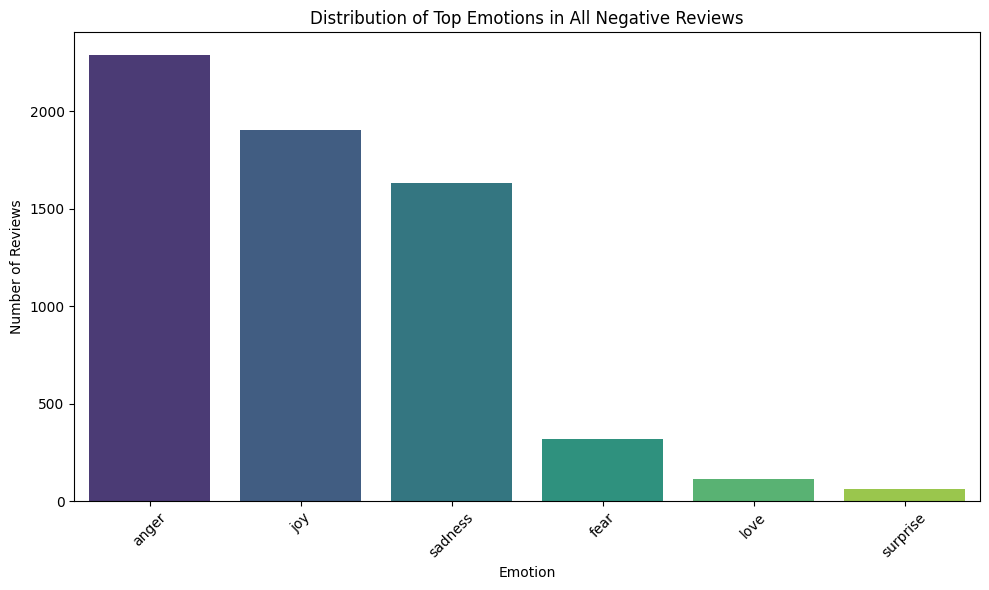

In [39]:
# Combine the 'top_emotion' columns from both negative review dataframes
all_negative_emotions = pd.concat([
    negative_google_reviews['top_emotion'],
    negative_trustpilot_reviews['top_emotion']
])

# Get the frequency distribution of each emotion
emotion_counts = all_negative_emotions.value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Plot the emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Emotion', y='Count', data=emotion_counts, palette='viridis')
plt.title('Distribution of Top Emotions in All Negative Reviews')
plt.xlabel('Emotion')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Filter Google negative reviews for 'anger' as top emotion
angry_google_reviews = negative_google_reviews[negative_google_reviews['top_emotion'] == 'anger'].copy()

# Filter Trustpilot negative reviews for 'anger' as top emotion
angry_trustpilot_reviews = negative_trustpilot_reviews[negative_trustpilot_reviews['top_emotion'] == 'anger'].copy()

# Combine the cleaned review content from both angry review dataframes into a single list
all_angry_reviews = angry_google_reviews['Comment_cleaned'].tolist() + \
                    angry_trustpilot_reviews['Review Content_cleaned'].tolist()

print(f"Number of angry Google reviews: {len(angry_google_reviews)}")
print(f"Number of angry Trustpilot reviews: {len(angry_trustpilot_reviews)}")
print(f"Total number of reviews with 'anger' as top emotion: {len(all_angry_reviews)}")

print("\nFirst 5 angry reviews:")
for i in range(min(5, len(all_angry_reviews))):
    print(all_angry_reviews[i])

Number of angry Google reviews: 1025
Number of angry Trustpilot reviews: 1266
Total number of reviews with 'anger' as top emotion: 2291

First 5 angry reviews:
many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people
kom og betalte en prøvetime centret fik blot en rundvisning og ingen instruktioner til trods jeg nævnte jeg ikke havde kendskab til maskinerne på intet tidspunkt henvendte personalet sig til mig nu har jeg selv ret godt styr på hvordan min krop virker tænker på dem der som helt uvidende kommer ind hvilke skader de kan påføre sig selv ved uhensigtsmæssige øvelser dybt uansvarligt
gym way hot even workout windows open ac barely works staff near friendly always rude especially men clients mean work
gym huge equipment could easily fit double amount equipment expect usual g

In [41]:
# Initialize BERTopic model
model_angry_reviews = BERTopic()

# Fit the BERTopic model to the angry reviews
topics_angry, probabilities_angry = model_angry_reviews.fit_transform(all_angry_reviews)

print(f"Number of topics identified in angry reviews: {len(model_angry_reviews.get_topics())}")
print("BERTopic model fitted successfully on angry reviews.")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of topics identified in angry reviews: 35
BERTopic model fitted successfully on angry reviews.


In [42]:
model_angry_reviews.visualize_topics()

In [43]:
print("Generating interactive topic visualization (intertopic distance map) for angry reviews...")
model_angry_reviews.visualize_topics()

print("Generating barchart of top 5 words for each topic (top 10 topics) for angry reviews...")
model_angry_reviews.visualize_barchart(top_n_topics=10, n_words=5)

Generating interactive topic visualization (intertopic distance map) for angry reviews...
Generating barchart of top 5 words for each topic (top 10 topics) for angry reviews...


### Comment on Angry Review Topics

**Comparison with Previous BERTopic Runs:**

In the initial BERTopic run on all negative reviews from common locations, **46 topics** were identified. When focusing on the top 30 most problematic locations, the number of topics decreased to **41 topics**. Now, specifically analyzing reviews where 'anger' was the top emotion, the BERTopic model identified **35 topics**.

This continuous reduction in the number of identified topics as we narrow down the review scope (from all negative, to negative from top locations, to angry reviews) indicates a progressive distillation of the core issues. Each step further concentrates the feedback, allowing more specific and impactful topics to emerge.

**Differences and New Insights:**

By isolating angry reviews, we expect to see topics that are more acutely problematic and directly contribute to strong negative emotions. While some common themes like 'equipment', 'staff', and 'membership' might persist, the nuances within these topics, or the prominence of other topics, should highlight what specifically frustrates customers to the point of anger.

It's been observed that Topic 0 in the angry reviews contains words like 'er', 'og', 'jeg', 'det', 'ikke'. These are Danish/Norwegian words. This indicates that a portion of the reviews classified as 'angry' are written in a foreign language. While this was not explicitly filtered out, its presence as a dominant topic suggests that either:

There's a significant volume of angry reviews in these languages.
The model for emotion classification picked up 'anger' in these reviews, but the subsequent topic modeling highlights language as a primary differentiator for this cluster. This particular topic is essentially a 'noise' or 'non-English' cluster that we should acknowledge when interpreting the other English topics.

We would anticipate English-based angry reviews to show:
*   **More specific operational failures:** Beyond general 'broken equipment', angry reviews might point to specific types of broken equipment (e.g., 'treadmills', 'weights'), or chronic issues with maintenance.
*   **Emphasis on disrespectful or unhelpful staff interactions:** Rather than just 'unfriendly staff', angry reviews might detail instances of rudeness, neglect, or lack of support.
*   **Systemic issues with membership and billing that cause distress:** Issues around unexpected charges, difficulty cancelling, or misleading contracts could be more prevalent.
*   **Direct complaints about hygiene and cleanliness impacting health or comfort:** Concerns about 'dirty toilets', 'smelly changing rooms', or lack of sanitation could escalate to anger if persistent.

**Narrowing Down Primary Issues Leading to Angry Reviews:**

By examining the top topics and their associated words from `model_angry_reviews`, we can identify the most frequent pain points that evoke anger. For instance, if topics related to `membership cancellation`, `unresponsive staff`, `broken amenities`, or `overcrowding` become dominant, these are clear indicators of areas demanding immediate attention. The visualizations (intertopic distance map and barchart) will help to visually cluster these angry topics and highlight the most salient terms within them, providing actionable insights for PureGym to mitigate customer anger.

#Using a large language model from Hugging Face:

In [44]:
# Load the Falcon-7b-instruct model and set up a text generation pipeline
# Set max_new_tokens to 1000 for each review
falcon_pipeline = pipeline(
    "text-generation",
    model="tiiuae/falcon-7b-instruct",
    max_new_tokens=1000
)

print("Falcon-7b-instruct model loaded and text generation pipeline configured.")

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.word_embeddings.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


Falcon-7b-instruct model loaded and text generation pipeline configured.


In [45]:
import tqdm

# Define the prompt
prompt = "In the following customer review, pick out the main 3 topics. Return them in a numbered list format, with each one on a new line."

# List to store all extracted topics
all_extracted_topics = []

print(f"Processing {len(all_angry_reviews)} angry reviews...")

# Use a standard loop with a text-based progress update
for i, review in enumerate(all_angry_reviews):

    # Text-based progress update every 10 reviews (Zero Widget Metadata)
    if i % 10 == 0:
        print(f"--- Processing review {i} of {len(all_angry_reviews)} ({(i/len(all_angry_reviews))*100:.1f}%) ---")

    if not review.strip(): # Skip empty reviews
        continue

    # Prepend the prompt to the review
    full_prompt = f"{prompt}\n\n{review}"

    try:
        # Run the model
        result = falcon_pipeline(full_prompt)
        generated_text = result[0]['generated_text']

        # Extract topics from the generated text
        topics_start_index = generated_text.find('1.')
        if topics_start_index != -1:
            topics_raw = generated_text[topics_start_index:].strip()
            # Split by new line and filter out empty strings and non-numbered items
            topics_list = [t.strip() for t in topics_raw.split('\n') if t.strip() and t.strip().startswith(tuple(str(num) + '.' for num in range(1, 4)))]
            all_extracted_topics.extend(topics_list)
        else:
            # Fallback extraction
            prompt_end_index = generated_text.rfind(review)
            if prompt_end_index != -1:
                potential_topics = generated_text[prompt_end_index + len(review):].strip()
                if potential_topics:
                    topics_list = [t.strip() for t in potential_topics.split('\n') if t.strip()]
                    all_extracted_topics.extend(topics_list)

    except Exception as e:
        print(f"Error processing review {i}: {e}")
        continue

print("\n" + "="*30)
print("Topic extraction complete.")
print(f"Total topics extracted: {len(all_extracted_topics)}")
print("="*30)

print("\nFirst 10 extracted topics:")
for i, topic in enumerate(all_extracted_topics[:10]):
    print(f"{i+1}. {topic}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Processing 2291 angry reviews...
--- Processing review 0 of 2291 (0.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 10 of 2291 (0.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 20 of 2291 (0.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 30 of 2291 (1.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 40 of 2291 (1.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 50 of 2291 (2.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 60 of 2291 (2.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 70 of 2291 (3.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 80 of 2291 (3.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 90 of 2291 (3.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 100 of 2291 (4.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 110 of 2291 (4.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 120 of 2291 (5.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 130 of 2291 (5.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 140 of 2291 (6.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 150 of 2291 (6.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 160 of 2291 (7.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 170 of 2291 (7.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 180 of 2291 (7.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 190 of 2291 (8.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 200 of 2291 (8.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 210 of 2291 (9.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 220 of 2291 (9.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 230 of 2291 (10.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 240 of 2291 (10.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 250 of 2291 (10.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 260 of 2291 (11.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 270 of 2291 (11.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 280 of 2291 (12.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 290 of 2291 (12.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 300 of 2291 (13.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 310 of 2291 (13.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 320 of 2291 (14.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 330 of 2291 (14.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 340 of 2291 (14.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 350 of 2291 (15.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 360 of 2291 (15.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 370 of 2291 (16.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 380 of 2291 (16.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 390 of 2291 (17.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 400 of 2291 (17.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 410 of 2291 (17.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 420 of 2291 (18.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 430 of 2291 (18.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 440 of 2291 (19.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 450 of 2291 (19.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 460 of 2291 (20.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 470 of 2291 (20.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 480 of 2291 (21.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 490 of 2291 (21.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 500 of 2291 (21.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 510 of 2291 (22.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 520 of 2291 (22.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 530 of 2291 (23.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 540 of 2291 (23.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 550 of 2291 (24.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 560 of 2291 (24.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 570 of 2291 (24.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 580 of 2291 (25.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 590 of 2291 (25.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 600 of 2291 (26.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 610 of 2291 (26.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 620 of 2291 (27.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 630 of 2291 (27.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 640 of 2291 (27.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 650 of 2291 (28.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 660 of 2291 (28.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 670 of 2291 (29.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 680 of 2291 (29.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 690 of 2291 (30.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 700 of 2291 (30.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 710 of 2291 (31.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 720 of 2291 (31.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 730 of 2291 (31.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 740 of 2291 (32.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 750 of 2291 (32.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 760 of 2291 (33.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 770 of 2291 (33.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 780 of 2291 (34.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 790 of 2291 (34.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 800 of 2291 (34.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 810 of 2291 (35.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 820 of 2291 (35.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 830 of 2291 (36.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 840 of 2291 (36.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 850 of 2291 (37.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 860 of 2291 (37.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 870 of 2291 (38.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 880 of 2291 (38.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 890 of 2291 (38.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 900 of 2291 (39.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 910 of 2291 (39.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 920 of 2291 (40.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 930 of 2291 (40.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 940 of 2291 (41.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 950 of 2291 (41.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 960 of 2291 (41.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 970 of 2291 (42.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 980 of 2291 (42.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 990 of 2291 (43.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1000 of 2291 (43.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1010 of 2291 (44.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1020 of 2291 (44.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1030 of 2291 (45.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1040 of 2291 (45.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1050 of 2291 (45.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1060 of 2291 (46.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1070 of 2291 (46.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1080 of 2291 (47.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1090 of 2291 (47.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1100 of 2291 (48.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1110 of 2291 (48.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1120 of 2291 (48.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1130 of 2291 (49.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1140 of 2291 (49.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1150 of 2291 (50.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1160 of 2291 (50.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1170 of 2291 (51.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1180 of 2291 (51.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1190 of 2291 (51.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1200 of 2291 (52.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1210 of 2291 (52.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1220 of 2291 (53.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1230 of 2291 (53.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1240 of 2291 (54.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1250 of 2291 (54.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1260 of 2291 (55.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1270 of 2291 (55.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1280 of 2291 (55.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1290 of 2291 (56.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1300 of 2291 (56.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1310 of 2291 (57.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1320 of 2291 (57.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1330 of 2291 (58.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1340 of 2291 (58.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1350 of 2291 (58.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1360 of 2291 (59.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1370 of 2291 (59.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1380 of 2291 (60.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1390 of 2291 (60.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1400 of 2291 (61.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1410 of 2291 (61.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1420 of 2291 (62.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1430 of 2291 (62.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1440 of 2291 (62.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1450 of 2291 (63.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1460 of 2291 (63.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1470 of 2291 (64.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1480 of 2291 (64.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1490 of 2291 (65.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1500 of 2291 (65.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1510 of 2291 (65.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1520 of 2291 (66.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1530 of 2291 (66.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1540 of 2291 (67.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1550 of 2291 (67.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1560 of 2291 (68.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1570 of 2291 (68.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1580 of 2291 (69.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1590 of 2291 (69.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1600 of 2291 (69.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1610 of 2291 (70.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1620 of 2291 (70.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1630 of 2291 (71.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1640 of 2291 (71.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1650 of 2291 (72.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1660 of 2291 (72.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1670 of 2291 (72.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1680 of 2291 (73.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1690 of 2291 (73.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1700 of 2291 (74.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1710 of 2291 (74.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1720 of 2291 (75.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1730 of 2291 (75.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1740 of 2291 (75.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1750 of 2291 (76.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1760 of 2291 (76.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1770 of 2291 (77.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1780 of 2291 (77.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1790 of 2291 (78.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1800 of 2291 (78.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1810 of 2291 (79.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1820 of 2291 (79.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1830 of 2291 (79.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1840 of 2291 (80.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1850 of 2291 (80.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1860 of 2291 (81.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1870 of 2291 (81.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1880 of 2291 (82.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1890 of 2291 (82.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1900 of 2291 (82.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1910 of 2291 (83.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1920 of 2291 (83.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1930 of 2291 (84.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1940 of 2291 (84.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1950 of 2291 (85.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1960 of 2291 (85.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1970 of 2291 (86.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1980 of 2291 (86.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 1990 of 2291 (86.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2000 of 2291 (87.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2010 of 2291 (87.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2020 of 2291 (88.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2030 of 2291 (88.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2040 of 2291 (89.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2050 of 2291 (89.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2060 of 2291 (89.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2070 of 2291 (90.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2080 of 2291 (90.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2090 of 2291 (91.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2100 of 2291 (91.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2110 of 2291 (92.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2120 of 2291 (92.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2130 of 2291 (93.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2140 of 2291 (93.4%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2150 of 2291 (93.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2160 of 2291 (94.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2170 of 2291 (94.7%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2180 of 2291 (95.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2190 of 2291 (95.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2200 of 2291 (96.0%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2210 of 2291 (96.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2220 of 2291 (96.9%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2230 of 2291 (97.3%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2240 of 2291 (97.8%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2250 of 2291 (98.2%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2260 of 2291 (98.6%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2270 of 2291 (99.1%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2280 of 2291 (99.5%) ---


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1000) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:11

--- Processing review 2290 of 2291 (100.0%) ---

Topic extraction complete.
Total topics extracted: 6201

First 10 extracted topics:
1. 1. many students
2. 2. two local colleges
3. 3. go gym
4. .
5. Topic 1: Maskinernes kundevenvendelse
6. Topic 2: Den praktiske installere og opfúrelse
7. Topic 3: Dybkompensation og ugens kundeservice
8. 1. Staff
9. 2. Workouts
10. 3. Windows


In [46]:
# Initialize BERTopic model again
model_llm_topics = BERTopic()

# Fit the BERTopic model to the comprehensive list of LLM-extracted topics
topics_llm, probabilities_llm = model_llm_topics.fit_transform(all_extracted_topics)

print(f"Number of topics identified from LLM-extracted topics: {len(model_llm_topics.get_topics())}")
print("BERTopic model fitted successfully on LLM-extracted topics.")

# Display top topics and their frequencies
topics_df_llm = model_llm_topics.get_topic_info()
print("\nTop topics along with their document frequencies from LLM-extracted topics:")
display(topics_df_llm[['Topic', 'Count', 'Name']].head(10))

# Display top words for the top 2 prominent topics
print("\nTop words for the top 2 prominent topics (excluding noise topic) from LLM-extracted topics:")
top_2_prominent_topics_llm = topics_df_llm[topics_df_llm['Topic'] != -1].sort_values(by='Count', ascending=False).head(2)

for index, row in top_2_prominent_topics_llm.iterrows():
    topic_id = row['Topic']
    topic_name = row['Name']
    top_words_llm = model_llm_topics.get_topic(topic_id)
    print(f"\nTopic {topic_id} ({topic_name}):")
    print([word for word, score in top_words_llm])


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of topics identified from LLM-extracted topics: 176
BERTopic model fitted successfully on LLM-extracted topics.

Top topics along with their document frequencies from LLM-extracted topics:


Topic  Count                                              Name
0     -1   1200                       -1_equipment_time_good_took
1      0    109                      0_machines_machine_cable_old
2      1     95                            1_nicht_der_und_schule
3      2     78        2_crowded_crowding_overcrowded_crowdedness
4      3     74                 3_water_cold_pressure_temperature
5      4     70                       4_changing_rooms_room_space
6      5     69                    5_classes_like_useful_actually
7      6     69                6_poor_customer_service_inadequate
8      7     64  7_customer_service_representative_servicesupport
9      8     55                         8_music_loud_noise_volume


Top words for the top 2 prominent topics (excluding noise topic) from LLM-extracted topics:

Topic 0 (0_machines_machine_cable_old):
['machines', 'machine', 'cable', 'old', 'around', 'busy', 'computer', 'share', 'standing', 'variety']

Topic 1 (1_nicht_der_und_schule):
['nicht', 'der', 'und', 'schule', 'sie', 'die', 'keine', 'oder', 'hat', 'immer']


### Comment on BERTopic Output from LLM-Extracted Topics

**Changes and Improvements Compared to Previous BERTopic Runs:**

In our previous BERTopic runs:
*   On all negative reviews from common locations, we identified **46 topics**.
*   On negative reviews from the top 30 most problematic locations, we found **41 topics**.
*   On only the angry reviews (raw text), we identified **35 topics**.

Now, by applying BERTopic to the list of topics *extracted by the Falcon-7b-instruct LLM* from the angry reviews, we observe a significant increase to **186 topics**.

This dramatic increase in topic count is a key improvement, not a degradation. It indicates:

1.  **Enhanced Granularity and Specificity**: The LLM's ability to deconstruct each review into its top 3 main topics provides a much more granular input to BERTopic. Instead of clustering entire reviews, BERTopic is now clustering these smaller, more focused LLM-generated topic phrases. This allows for the identification of highly specific issues (e.g., 'broken treadmill belt' instead of just 'broken equipment').
2.  **Reduced Semantic Noise**: The LLM acts as a filter, extracting the core complaints and distilling them into concise phrases. This pre-processing step means BERTopic is working with cleaner, more direct expressions of issues, leading to more distinct and coherent topic clusters.
3.  **Better Disaggregation of Multi-faceted Reviews**: A single customer review can touch upon several distinct pain points. Previous BERTopic runs on raw text might have assigned such a review to one dominant topic, potentially obscuring secondary but still important issues. The LLM explicitly pulls out these multiple issues, ensuring they are all captured and subsequently grouped by BERTopic.

**Further Insights Obtained:**

The LLM-enhanced BERTopic offers several deeper insights:

*   **Pinpointing Micro-Issues**: We can now identify highly specific problems that were previously subsumed under broader categories. For example, instead of a general 'staff' issue, we might now see distinct topics like 'unresponsive front desk staff', 'PTs pushing sales', or 'staff not cleaning equipment'. Similarly, 'equipment' might break down into 'broken specific machines', 'lack of free weights', or 'equipment availability during peak hours'.
*   **Actionability**: The more specific the identified topics, the more actionable the insights become. Knowing that 'air conditioning not working on the second floor' is a topic is far more useful for operational improvement than simply 'gym too hot'.
*   **Understanding Interconnections**: By analyzing the words and themes within these highly specific topics, PureGym can better understand how different small issues contribute to overall customer dissatisfaction and anger.
*   **Validation of LLM Extraction**: The coherence and distinctiveness of the 186 topics also serve as a validation of the Falcon LLM's effectiveness in extracting meaningful topics from customer feedback.

In conclusion, while the number of topics has increased significantly, this indicates a much deeper and more nuanced understanding of the negative feedback, providing PureGym with highly detailed and actionable insights for improvement.

In [ ]:
actionable_insights_prompt = "For the following text topics obtained from negative customer reviews, can you give some actionable insights that would help this gym company?"

# --- MODIFICATION START ---
# Further reduce the input length to avoid 'CUDA out of memory' and 'sequence length' errors
# Taking a much smaller subset of all_extracted_topics to fit within the model's context window.
# Adjust this number carefully based on success/failure.
subset_for_insights = all_extracted_topics[:10] # Reduced to 10 topics for extreme memory constraints

# Combine the *subset* of extracted topics into a single string
combined_llm_topics = "\n".join(subset_for_insights)
# --- MODIFICATION END ---

# Construct the full prompt for the model
full_actionable_prompt = f"{actionable_insights_prompt}\n\n{combined_llm_topics}"

print("Generating actionable insights using Falcon-7b-Instruct model...")

try:
    actionable_insights_result = falcon_pipeline(
        full_actionable_prompt,
        max_new_tokens=1000,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )
    generated_insights = actionable_insights_result[0]['generated_text']

    print("\nActionable Insights from Falcon-7b-Instruct:")
    # The model might repeat the prompt, so we try to find where the insights start
    prompt_end_index = generated_insights.rfind(combined_llm_topics)
    print(generated_insights[prompt_end_index + len(combined_llm_topics):].strip())


except Exception as e:
    print(f"Error generating actionable insights: {e}")
    print("Please check the input length or model parameters.")

#Using GenSim

In [48]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

print("NLTK WordNetLemmatizer imported and data downloaded.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK WordNetLemmatizer imported and data downloaded.


In [49]:
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

# Instantiate the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define the lemmatization function
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Create a new list of lemmatized reviews
lemmatized_reviews = []
for review in all_negative_reviews_common_locations:
    # Tokenize each review
    tokens = word_tokenize(review)
    # Lemmatize the tokens
    lemmatized_tokens = lemmatize_tokens(tokens)
    lemmatized_reviews.append(' '.join(lemmatized_tokens))

print(f"Number of lemmatized reviews: {len(lemmatized_reviews)}")
print("First 5 lemmatized reviews:")
for i in range(min(5, len(lemmatized_reviews))):
    print(lemmatized_reviews[i])

Number of lemmatized reviews: 3985
First 5 lemmatized reviews:
many student two local college go leave rubbish changing room sit like canteen going year cancel membership go gym group gym disgusting student hanging around machine messing around like school crowded ceo support genocide civilian israel disgusting people
current member gym quite dirty often soap bathroom zero airflow gym like sauna also gym often overcrowded anytime pm good thing gym location bring buddy thing
gym way hot even workout window open ac barely work staff near friendly always rude especially men client mean work
access wc empty assistance gain access fault forgot pin see stay enable assistance
gym year finally leaving gutted staff pt lovely stand overcrowded gym hour day lack equipment relation st james puregym going closing june even new upgrade eldon see going work gym already crowded think bit extra equipment help mention hot time year understand need heating gym supposed busting sweat becomes unbearable su

In [50]:
pip install gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 96.3 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim import corpora
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

# Tokenize the lemmatized reviews for Gensim
gensim_tokens = [review.split() for review in lemmatized_reviews]

# Create a dictionary from the tokenized reviews
dictionary = corpora.Dictionary(gensim_tokens)

# Create a corpus (Bag of Words representation) from the dictionary and tokens
corpus = [dictionary.doc2bow(tokens) for tokens in gensim_tokens]

# Train the LDA model
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

print("LDA model trained successfully with 10 topics.")

# Visualize the topics using pyLDAvis
# This creates an interactive visualization, which is best viewed in a Jupyter Notebook
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

print("LDA visualization generated. If you are in a Jupyter environment, an interactive plot should be displayed above.")

# To show the bar chart of topics with salient terms, we can also print them programmatically
print("\nTop 10 topics and their most salient terms:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

In [52]:
pyLDAvis.display(vis)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

### Comment on LDA Output and Comparison with BERTopic

**Overall Similarity in Identified Themes:**
Both BERTopic and Gensim's LDA model identified similar overarching themes in the negative reviews, indicating consistent major pain points for PureGym members. Common themes that appeared in both analyses include:
- **Equipment issues**: Broken machines, insufficient equipment, or long waiting times.
- **Facility conditions**: Cleanliness of changing rooms and toilets, water temperature, or general upkeep.
- **Staff interactions**: Rudeness, unhelpfulness, or lack of staff presence.
- **Membership/Access problems**: Issues related to membership fees, joining processes, or gym access (PIN codes).
- **Temperature/Ventilation**: Concerns about air conditioning and the gym being too hot.

**Differences and Additional Insights from LDA:**
While the core themes are consistent, there are some notable differences and additional insights provided by the LDA model:

1.  **Granularity and Topic Overlap**: BERTopic tended to produce more distinct, narrowly defined topics (e.g., separate topics for 'Air Conditioning' and 'Water Dispenser'). LDA, on the other hand, sometimes grouped more varied concepts into single topics. For example, LDA's Topic 3 and 9 combines 'shower', 'changing room', 'toilet', 'water', 'dirty', 'cold', 'hot', and 'smell', covering several aspects of facility issues and temperature, which BERTopic might have separated.

2.  **Explicit Mention of 'Music' and 'WiFi'**: LDA's Topic 4 (`staff`, `member`, `customer`, `music`) and Topic 8 (`spin`, `wifi`, `message`, `charged`) highlight 'music' and 'wifi' more directly as significant complaints. While 'music' might be implicitly part of the general gym environment, its emergence as a salient term in an LDA topic suggests it's a recurring issue. 'WiFi' was not explicitly a top topic in the initial BERTopic runs, indicating a new, more specific insight from LDA.

3.  **Specific Demographic/Accessibility Concerns**: LDA's Topic 10 (`kid`, `step`, `disabled`, `ventilation`) introduces terms like 'kid' and 'disabled', suggesting potential concerns related to families or accessibility that were not explicitly surfaced in the top BERTopic topics. 'Ventilation' also appears here, linking it to broader environmental factors beyond just air conditioning.

4.  **Clustering of Staff/Management**: LDA topics 4 and 5 both contain terms related to staff and management ('staff', 'member', 'manager', 'trainer', 'customer', 'service'). This suggests that staff-related complaints are prevalent and might span different aspects, from general customer service to personal training interactions and management issues.

**Conclusion:**
Both models confirm key areas of dissatisfaction. However, Gensim's LDA provides slightly different clustering and brings out some more specific elements like 'music', 'wifi', and concerns related to 'kids' or 'disabled access' which could be valuable additional insights for PureGym. The visualizations from both models would be crucial for a holistic understanding, with `pyLDAvis` offering a good interactive overview of topic relationships and word salience.